## Import Packages

In [1]:
import os
import subprocess
from IPython.display import display, HTML, Image
import io
from operator import itemgetter
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
import copy

%matplotlib inline
%qtconsole

## Define Super Learner Classifier

The *Super Learner* is a heterogeneous stacked ensemble classifier. This is a classification model that uses a set of base classifiers of different types, the outputs of which are then combined in another classifier at the stacked layer. The Super Learner was described in [(van der Laan et al, 2007)](https://pdfs.semanticscholar.org/19e9/c732082706f39d2ba12845851309714db135.pdf) but the stacked ensemble idea has been around for a long time.

### Define the SuperLearnerClassifier Class



In [2]:
"""
This is the Super learner class which train the base classifier and stack layer classifier. All the method associated with the stack
layer classifier is encpsulated in the class. It will call normally as anyother classifier. After calling this classifier, the
same object can be used in calling fit, predict and predict_proba method.
"""

class SuperLearnerClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, k=5, stackclf= tree.DecisionTreeClassifier(), pre_pro= False, Ori_Des = False):
    
        self.stackclf = stackclf   # This is the class constucter. Taking values from the call and handel here
        self.pre_pro = pre_pro
        self.k = k
        self.Ori_Des= Ori_Des
     
    def fit(self, X,y):  
        
# This  is a Fit method used to fit all the classifier. It fits the stack layer classifier on output of the base classifiers
        
        newpdt = pd.DataFrame()      # Taking data frame 
        newplr = pd.DataFrame()
        newpknn = pd.DataFrame()
        newprf = pd.DataFrame()
        newpnb = pd.DataFrame()
        newpbag = pd.DataFrame()
        bag =[]
        nb = []
        rrf = []
        rdt = []
        rLR = []
        rKNN = []
        self.label = y
       
        kf = KFold(n_splits=self.k)   # this is K vold validation code which split the data into folds
        kf.get_n_splits(X)
        xv = X.values

        KFold(n_splits=self.k, random_state=None, shuffle=False)
       
        for train_index, test_index in kf.split(X):
 

            X_train, X_test = xv[train_index], xv[test_index]
            y_train, y_test = y[train_index], y[test_index]
# Here fitting the classifiers using K fold
            self.DT_trees = tree.DecisionTreeClassifier(criterion="gini", min_samples_split = 200, max_depth=9)
            self.DT_trees.fit(X_train,y_train)
            
            self.Log_Reg = linear_model.LogisticRegression()
            self.Log_Reg = self.Log_Reg.fit(X_train,y_train)
                         
            self.KNNCla = neighbors.KNeighborsClassifier()
            self.KNNCla = self.KNNCla.fit(X_train,y_train)
            
            self.Ran_For = ensemble.RandomForestClassifier(n_estimators=300, max_features = 3, min_samples_split=200)
            self.Ran_For.fit(X_train,y_train)
            
            self.Nbc = GaussianNB()                # weak classifier
            self.Nbc = self.Nbc.fit(X_train,y_train)
                       
            self.bagclf = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), \
                                      n_estimators=10)
            self.bagclf.fit(X_train,y_train)
# getting the predictions below on the trained classifiers            
            label_d14 = self.DT_trees.predict(X_test)
            rdt.append(label_d14)
            label_predlrr = self.Log_Reg.predict(X_test)
            rLR.append(label_predlrr)
            label_KNNn = self.KNNCla.predict(X_test)
            rKNN.append(label_KNNn)                   
            Ran_pre = self.Ran_For.predict(X_test)
            rrf.append(Ran_pre)
            Nbc_pre = self.Nbc.predict(X_test)
            nb.append(Nbc_pre)
            bag_pred = self.bagclf.predict(X_test)
            bag.append(bag_pred)

# Getting the probability output on the fitted classifiers

            pp1 = self.DT_trees.predict_proba(X_test)
            pdtt = pd.DataFrame(pp1)
            v1 = ["M_"+ str(i) for i in range(1,11)]  # these v value for column names
            pdtt.columns =v1
                   
            pp2 = self.Log_Reg.predict_proba(X_test)
            pplr= pd.DataFrame(pp2)
            v2 = ["M_"+ str(i) for i in range(11,21)]
            pplr.columns =v2
            
            pp3 = self.KNNCla.predict_proba(X_test)
            ppknn= pd.DataFrame(pp3)
            v3 = ["M_"+ str(i) for i in range(21,31)]
            ppknn.columns =v3
               
            pp4 = self.Ran_For.predict_proba(X_test)
            pprf= pd.DataFrame(pp4)
            v4 = ["M_"+ str(i) for i in range(31,41)]
            pprf.columns =v4
            
            pp5 = self.Nbc.predict_proba(X_test)
            ppnb= pd.DataFrame(pp5)
            v5 = ["M_"+ str(i) for i in range(41,51)]
            ppnb.columns =v5
            
            pp6 = self.bagclf.predict_proba(X_test)
            ppbag= pd.DataFrame(pp6)
            v6 = ["M_"+ str(i) for i in range(51,61)]
            ppbag.columns =v6
            
            newpdt= pd.concat([newpdt, pdtt])
            newplr= pd.concat([newplr, pplr])
            newpknn= pd.concat([newpknn, ppknn])
            newprf= pd.concat([newprf, pprf])
            newpnb= pd.concat([newpnb, ppnb])
            newpbag= pd.concat([newpbag, ppbag])
            
            
# here I am fitting the classifier with the whole X and y as last fold of K fold I applied above have trained on 75% of the data only so filling the gap I am again training the clf on fully data too.            
        self.DT_trees= self.DT_trees.fit(X,y)
        self.Log_Reg = self.Log_Reg.fit(X,y)
        self.KNNCla = self.KNNCla.fit(X,y)
        self.Ran_For = self.Ran_For.fit(X,y)
        self.Nbc = self.Nbc.fit(X,y)
        self.bagclf = self.bagclf.fit(X,y)
        
# Here concating the predicyed values from predict_proba method of the base classifiers                   
            
        final_probip = pd.concat([newpdt, newplr, newpknn, newprf, newpnb, newpbag], axis =1)
        final_probip["label"] = self.label
       
        FXp = final_probip.iloc[:,:-1]
        Fyp = final_probip["label"]
        X=X.reset_index(drop=True)
        final_probip=final_probip.reset_index(drop=True)
        
        With_Orig = pd.concat([X,final_probip], axis =1)
        With_Orig["label"] = self.label
        
        FXo = With_Orig.iloc[:,:-1]
        Fyo = With_Orig["label"]
              
 # for better use of the predicted value I have put them into the pandas data frame and used the array to append the predicted value of each iteration of k fold and then for taking them row bise I have used the reshape feature of numpy array            
        
        DtpreData = pd.DataFrame((np.array(rdt)).reshape(np.array(rdt).size, 1))
        LrpreData = pd.DataFrame((np.array(rLR)).reshape(np.array(rLR).size, 1))
        KnnpreData = pd.DataFrame((np.array(rKNN)).reshape(np.array(rKNN).size, 1))
        RafpreData = pd.DataFrame((np.array(rrf)).reshape(np.array(rrf).size, 1))
        NabpreData = pd.DataFrame((np.array(nb)).reshape(np.array(nb).size, 1))    
        BagpreData = pd.DataFrame((np.array(bag)).reshape(np.array(bag).size, 1))

# Merging the output of the predict method         
        PreInp = pd.concat([self.label, DtpreData, LrpreData, KnnpreData, RafpreData, NabpreData, BagpreData], axis =1)
        PreInp.columns = ["Ori_Labels","DecTree", "LR", "KNN", "RandFor", "NaiveBa", "Bagging"]
        FX = PreInp.iloc[:,1:]      # extracting the X and y from the data
        Fy = PreInp["Ori_Labels"]
        PreInp=PreInp.reset_index(drop=True)
        
        With_Orig1 = pd.concat([PreInp, X], axis =1)
        FXpreo = With_Orig1.iloc[:,1:]    # Extracting the X and y from the data which has Orignal feature
        Fypreo = With_Orig1.iloc[:,:1]
        
# here I have copied the classifier instance for predict and predict_proba method using the deepcopy feature       
        self.dtpre = copy.deepcopy(self.DT_trees)
        self.lrpre = copy.deepcopy(self.Log_Reg)
        self.knnpre = copy.deepcopy(self.KNNCla)
        self.Rfpre = copy.deepcopy(self.Ran_For)
        self.Nbpre = copy.deepcopy(self.Nbc)
        self.bagipre = copy.deepcopy(self.bagclf)
                               
        self.dtpre1 = copy.deepcopy(self.DT_trees)
        self.lrpre1 = copy.deepcopy(self.Log_Reg)
        self.knnpre1 = copy.deepcopy(self.KNNCla)
        self.Rfpre1 = copy.deepcopy(self.Ran_For)
        self.Nbpre1 = copy.deepcopy(self.Nbc)
        self.bagipre1 = copy.deepcopy(self.bagclf)
        
        self.PPdtpre = copy.deepcopy(self.DT_trees)
        self.PPlrpre = copy.deepcopy(self.Log_Reg)
        self.PPknnpre = copy.deepcopy(self.KNNCla)
        self.PPRfpre = copy.deepcopy(self.Ran_For)
        self.PPNbpre = copy.deepcopy(self.Nbc)
        self.PPbagipre = copy.deepcopy(self.bagclf)
        

        
# Here I have made the copy for the stack classifier which gonna use in below conditions.
        stackp = copy.deepcopy(self.stackclf)
        stack1 = copy.deepcopy(self.stackclf)
        stackpro = copy.deepcopy(self.stackclf)       
        stackpro1 = copy.deepcopy(self.stackclf)
        
# Here is the main codition whether the stack classifier is Decision tree or Logistic Regression
# Whether to use the output of Predict method or predict_proba method to fit the stack classifier
# Whether to take the Orignal descriptive feature or not
        
        if self.pre_pro == True:         # this is condition for predict or predict_proba method
            if self.Ori_Des == True:             # To take Orignal Descriptive Feature or not
                self.DT_treesStaProOrg= stackpro.fit(FXo,Fyo)       
            else:
                self.DT_treesStaProNorg= stackpro1.fit(FXp,Fyp)   #stack classifier # predict proba
                
            
        elif self.pre_pro == False:
            if self.Ori_Des == True:
                self.DT_treesStaPreOrg= stackp.fit(FXpreo,Fypreo)
            else:
                self.DT_treesStaPreNorg= stack1.fit(FX,Fy)   # stack classifier predict waala
                              
        else:
                                  
            self.DT_treesStaPre= stack1.fit(FX,Fy)   # This is for the default use of stack classifier i.e. Decision Tree trained on predicted output with no Orignal descriptive feature 

        
        return self
   
    def predict(self, xtest):
        
# This is a predict method which predict the values on classifiers. I have take the predict and predict_proba method here.
# To predict the value according to the condition I have taken predict and predict_proba method's prediction output
# Also,I have added the orignal feature of the input data to this method for task 8
                
        label_d14 = self.dtpre.predict(xtest)
        dtp= pd.DataFrame(label_d14)
        
        label_predlrr = self.lrpre.predict(xtest)
        lrp = pd.DataFrame(label_predlrr)
        
        label_KNNn = self.knnpre.predict(xtest)
        knnp = pd.DataFrame(label_KNNn)
        
        Ran_pre = self.Ran_For.predict(xtest)
        ranfp = pd.DataFrame(Ran_pre)
        
        Nbc_pre = self.Nbc.predict(xtest)
        nbcp = pd.DataFrame(Nbc_pre)
        
        bag_pred = self.bagclf.predict(xtest)
        bagp = pd.DataFrame(bag_pred)
                
# here Concating the values from predict method run on base classifiers        
        PreInpF = pd.concat([dtp, lrp, knnp, ranfp, nbcp,bagp], axis =1)
        PreInpF.columns = ["DecTree", "LR", "KNN", "RanFor", "NaiveB", "Bagging"]       
           
# for the condition I am predicting on the predict_proba method below  
        dtppi = self.PPdtpre.predict_proba(xtest)
        dtpp = pd.DataFrame(dtppi)
                
        lrppi = self.PPlrpre.predict_proba(xtest)
        lrpp = pd.DataFrame(lrppi)
        
        knnppi = self.PPknnpre.predict_proba(xtest)
        knnpp = pd.DataFrame(knnppi)
        
        Ran_prei = self.PPRfpre.predict_proba(xtest)
        ranfpp = pd.DataFrame(Ran_prei)
        
        Nbc_prei = self.PPNbpre.predict_proba(xtest)
        nbcpp = pd.DataFrame(Nbc_prei)
        
        bag_predi = self.PPbagipre.predict_proba(xtest)
        bagpp = pd.DataFrame(bag_predi)
        
# Now concating the output of the predict_proba method for predicting on the stack classifiers                         
        ProPreInp = pd.concat([dtpp, lrpp, knnpp, ranfpp, nbcpp, bagpp], axis =1)
        
        ProPreInp = ProPreInp.reset_index(drop=True)
        xtest = xtest.reset_index(drop=True)
        
        Pro_Orig1 = pd.concat([ProPreInp, xtest], axis =1)   # Concating the predict_proba o/p with orignal featue passed to this method
        
                
        Pre_Orig1 = pd.concat([PreInpF, xtest], axis =1)  # Concating the predict method output with Orignal feature
        
        
# here are the condition for Probability, prediction and Orignal descriptive feature
               
        if self.pre_pro == True:       # this is for whether probability is to be taken or not
            if self.Ori_Des == True:    # Thsi is for whether the Orignal feature is taken or not
                
                Final_Pred= self.DT_treesStaProOrg.predict(Pro_Orig1)
                
            else:
                Final_Pred= self.DT_treesStaProNorg.predict(ProPreInp)
                
            
        elif self.pre_pro == False:
            if self.Ori_Des == True:
                
                Final_Pred= self.DT_treesStaPreOrg.predict(Pre_Orig1)
                
                
            else:
                Final_Pred= self.DT_treesStaPreNorg.predict(PreInpF)
              
        
        return Final_Pred
    
    def predict_proba(self, xtest):
        
# This is the predict_proba method used for predicting the probability of the target feature. It given 10 output with probability value for being one targer feature or another
# here I am using the predict and predict_proba method of the base classifiers to predict on the stack layer classifier on given condition                
        
        label_d = self.dtpre1.predict(xtest)
        dp= pd.DataFrame(label_d)
        
        label_prelrr = self.lrpre1.predict(xtest)
        lp = pd.DataFrame(label_prelrr)
        
        label_KNn = self.knnpre1.predict(xtest)
        knp = pd.DataFrame(label_KNn)
        
        Ran_pre = self.Ran_For.predict(xtest)
        ranfp = pd.DataFrame(Ran_pre)
        
        Nbc_pre = self.Nbc.predict(xtest)
        nbcp = pd.DataFrame(Nbc_pre)
        
        bag_pred = self.bagclf.predict(xtest)
        bagp = pd.DataFrame(bag_pred)
                
# merging the output of the predict method 
        PreInpF = pd.concat([dp, lp, knp, ranfp, nbcp,bagp], axis =1)
        PreInpF.columns = ["DecTree", "LR", "KNN", "RanFor", "NaiveB", "Bagging"]     
                
        dtppi = self.PPdtpre.predict_proba(xtest)  # Predicting the values on base classifier's predict_proba method
        dtpp = pd.DataFrame(dtppi)
                
        lrppi = self.PPlrpre.predict_proba(xtest)
        lrpp = pd.DataFrame(lrppi)
        
        knnppi = self.PPknnpre.predict_proba(xtest)
        knnpp = pd.DataFrame(knnppi)
        
        Ran_prei = self.PPRfpre.predict_proba(xtest)
        ranfpp = pd.DataFrame(Ran_prei)
        
        Nbc_prei = self.PPNbpre.predict_proba(xtest)
        nbcpp = pd.DataFrame(Nbc_prei)
        
        bag_predi = self.PPbagipre.predict_proba(xtest)
        bagpp = pd.DataFrame(bag_predi)
        
# concating the predict_proba output of the base classifiers
        
        ProPreInp = pd.concat([dtpp, lrpp, knnpp, ranfpp, nbcpp, bagpp], axis =1)
        
        ProPreInp = ProPreInp.reset_index(drop=True)
        xtest = xtest.reset_index(drop=True)
        
        Pro_Orig1 = pd.concat([ProPreInp, xtest], axis =1)    # This is a merger of Orignal feature and Predict_proba method output of the base learner
        #PreInpF = PreInpF.reset_index(drop=True)
                
        Pre_Orig1 = pd.concat([PreInpF, xtest], axis =1)        # this is merger of orignal feature and predict method output of the base learner
        
        if self.pre_pro == True:
            if self.Ori_Des == True:
                Final_Pred= self.DT_treesStaProOrg.predict_proba(Pro_Orig1)
                
            else:
                Final_Pred= self.DT_treesStaProNorg.predict_proba(ProPreInp)
                
            
        elif self.pre_pro == False:
            if self.Ori_Des == True:
                                
                Final_Pred= self.DT_treesStaPreOrg.predict_proba(Pre_Orig1)
                
                
            else:
                Final_Pred= self.DT_treesStaPreNorg.predict_proba(PreInpF)
                
                        
        
        return Final_Pred
    
    



### Test the SuperLearnerClassifier

The input of the Super learner classifier are described below:
K = it is a k fold value. by default it is set as 5 in the class above. Range 5-10 is good.
stackclf = It is a stack layer classifier aka final classifier it takes either of two values from tree.DecisionTreeClassifier() and linear_model.LogisticRegression() and use for the stack layer. Make sure it is imported from the scikit learn packages first. By default it is set as tree.DecisionTreeClassifier()
pre_pro = It is check for whether stack layer takes the input from the Predict Method or Predict_proba method of the base classifiers. By default is set as false i.e. Prediction method of base classifiers will be used to fit the stack model.
Ori_Des = This is a check for whether to include the Orignal descrptive features or not. By default it is set as false i.e. Orignal features will not be added.

##### To run the below code, run the code written in Pre-process & Partition Data section to load the data first and partions 

In [11]:
clfdt = SuperLearnerClassifier(k =2, stackclf= tree.DecisionTreeClassifier(), pre_pro= False, Ori_Des = False)
clfdt.fit(X,y)
clfdtpre=clfdt.predict(X_test1)
clfdt.predict_proba(X_test1)
accuracy1 = metrics.accuracy_score(y_test1, clfdtpre)
print("Accuracy of Stack DT: " +  str(accuracy1))

clflr = SuperLearnerClassifier(k=2, stackclf=linear_model.LogisticRegression(), pre_pro=False, Ori_Des=True)
clflr.fit(X,y)
clfpre=clflr.predict(X_test1)
clflr.predict_proba(X_test1)

accuracy2 = metrics.accuracy_score(y_test1, clfpre)
print("Accuracy of Stack LR: " +  str(accuracy2))

Accuracy of Stack DT: 0.808333333333


C:\Users\Prateek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Stack LR: 0.941666666667


## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [4]:
data_sampling_rate = 0.01

Setup the number of folds for all grid searches (should be 5 - 10)

In [5]:
cv_folds = 2

### Load Dataset

Load the dataset and explore it.

In [7]:
dataset = pd.read_csv("fashion-mnist_train.csv")
dataset = dataset.sample(frac=data_sampling_rate) #take sample from the dataset so everyhting runs smoothly define in above cell
dataset = dataset.reset_index(drop=True)
display(dataset.shape)


(600, 785)

### Pre-process & Partition Data

In [9]:
y= dataset["label"]
X = dataset.iloc[:,1:]
X = X/255     # for normalizing teh data

Partition of the data is given below

In [10]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, random_state=0, train_size = 0.8)

## Train and Evaluate a Simple Model

Train a Super Learner Classifier using the prepared dataset

In [12]:
#Calling the Super learner with the given parameters
clf1 = SuperLearnerClassifier(stackclf= tree.DecisionTreeClassifier(), pre_pro= False, Ori_Des = True, k =2)
clf1.fit(X,y)
clf1pre=clf1.predict(X_test1)
clf1.predict_proba(X_test1)
accuracydtS = metrics.accuracy_score(y_test1, clf1pre) # , normalize=True, sample_weight=None
print("Accuracy of DT stack layer: " +  str(accuracydtS))

clf2 = SuperLearnerClassifier(k=2, stackclf=linear_model.LogisticRegression(), pre_pro=False, Ori_Des=True)
clf2.fit(X,y)
clf2pre=clflr.predict(X_test1)
clf2.predict_proba(X_test1)
accuracylrS = metrics.accuracy_score(y_test1, clf2pre) # , normalize=True, sample_weight=None
print("Accuracy of LR Stack layer: " +  str(accuracylrS))

Accuracy of DT stack layer: 1.0


C:\Users\Prateek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of LR Stack layer: 0.941666666667


In [13]:
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()

In [1]:
# for stack layer 1st which is Decision tree
pred1 = clf1.predict(X_test1)

#Print performance details
accuracy = metrics.accuracy_score(y_test1, pred1) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["DT_Stack_layer"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test1, pred1))

#Print confusion matrix
print(metrics.confusion_matrix(y_test1, pred1))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test1), pred1, rownames=['True'], colnames=['Predicted'], margins=True)

In [3]:
# for 2nd stack layer which is Logistice Regression
pred2 = clf2.predict(X_test1)

#Print performance details
accuracy = metrics.accuracy_score(y_test1, pred2) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["LR_Stack_layer"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test1, pred2))

#Print confusion matrix
print(metrics.confusion_matrix(y_test1, pred2))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test1), pred2, rownames=['True'], colnames=['Predicted'], margins=True)

## Cross Validation Experiment

In [2]:
# this is for the cross validation performed on the Super Learner classifiers.
my_model = SuperLearnerClassifier()
scores = cross_val_score(my_model, X, y, cv=3)
print(scores)

## Comparing the Performance of Different Stack Layer Approaches

In [17]:
print("This is the comparision between both the stack layer classifier with hyperparameters")

dtclf1 = SuperLearnerClassifier(k=4, stackclf=tree.DecisionTreeClassifier(), pre_pro=False, Ori_Des=False)
dtclf1.fit(X,y)
dtpre1=dtclf1.predict(X_test1)
accuracydt1 = metrics.accuracy_score(y_test1, dtpre1)

dtclfp2 = SuperLearnerClassifier(k=4, stackclf=tree.DecisionTreeClassifier(), pre_pro=True, Ori_Des=False)
dtclfp2.fit(X,y)
dtprep2=dtclfp2.predict(X_test1)
accuracydtp2 = metrics.accuracy_score(y_test1, dtprep2)

data = np.array([['','Accuracy'],['Prediction',accuracydt1], ['Probability',accuracydtp2]])
                
AccuracyDT=pd.DataFrame(data=data[1:,1:],index=data[1:,0], columns=data[0,1:])

print("DT Stack Accuracy:",AccuracyDT)


lrclf1 = SuperLearnerClassifier(k=4, stackclf=linear_model.LogisticRegression(), pre_pro=False, Ori_Des=False)
lrclf1.fit(X,y)
lrpre1=lrclf1.predict(X_test1)
accuracylr1 = metrics.accuracy_score(y_test1, lrpre1)

lrclf2 = SuperLearnerClassifier(k=4, stackclf=linear_model.LogisticRegression(), pre_pro=True, Ori_Des=False)
lrclf2.fit(X,y)
lrpre2=lrclf2.predict(X_test1)
accuracylr2 = metrics.accuracy_score(y_test1, lrpre2)


datalr = np.array([['','Accuracy'],['Prediction',accuracylr1], ['Probability',accuracylr2]])
                
Accuracylr=pd.DataFrame(data=datalr[1:,1:],index=data[1:,0], columns=data[0,1:])

print("Logistice_Reg Stack Accuracy:", Accuracylr)


This is the comparision between both the stack layer classifier with hyperparameters
DT Stack Accuracy:                    Accuracy
Prediction   0.858333333333
Probability  0.141666666667
Logistice_Reg Stack Accuracy:                    Accuracy
Prediction   0.608333333333
Probability             0.7


## Grid Search Through SuperLearnerClassifier Architectures & Parameters

In [6]:
# I perform grid serach on the both type of stack classifier below

l = list()

param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [200]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=cv_folds, verbose = 2, \
                            return_train_score=True)
my_tuned_tree.fit(X_train1, y_train1)

# Print details
#print("Best parameters set found on Descision Tree:")
#display(my_tuned_tree.best_params_)
k.append(my_tuned_tree.best_params_)

param_grid1 = [
 {'multi_class': ['ovr'], 
 'C': [x / 10.0 for x in range(2, 21, 2)],
 'solver':['liblinear'],
  'max_iter':[1000]}
]

# Perform the search
my_tuned_model1 = GridSearchCV(linear_model.LogisticRegression(), param_grid1, cv=cv_folds, verbose = 2)
my_tuned_model1.fit(X_train1, y_train1)

# Print details
#print("Best parameters set found on development set:")
#print(my_tuned_model1.best_params_)
l.append(my_tuned_model1.best_params_)

param_grid2 = [
               {'n_neighbors': list(range(1, 50, 5))}
]


print("Best Parameters list")
for i in k:
    print(i)

In [1]:
# This is the grid search code for getting the good parameters for the Super learner classifiers.
param_grid ={'stackclf': [linear_model.LogisticRegression(), tree.DecisionTreeClassifier()], \
             'pre_pro': ['True', 'False']}

# Performing the search below:
my_tuned_tree = GridSearchCV(SuperLearnerClassifier(), \
                                param_grid, cv=5, verbose = 2, \
                            return_train_score=True)
my_tuned_tree.fit(X, y)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
model_tuned_params_list["Tuned Tree"] = my_tuned_tree.best_params_
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

## Evaluating the Impact of Adding Original Descriptive Features at the Stack Layer

Evaluate the impact of adding original descriptive features at the stack layer.

For evaluting the impact of adding the orignal feature I have used the parameter called Ori_Des. Below is the comparision of the accuracy before and afte adding the Orignal features.

In [236]:
print("This is the comparision between classifier before and after adding the orignal features")

# In this code orignal feature is not added as flag named Ori_Des is set False
dtclf1 = SuperLearnerClassifier(k=3, stackclf=tree.DecisionTreeClassifier(), pre_pro=False, Ori_Des=False)
dtclf1.fit(X,y)
dtpre1=dtclf1.predict(X_test1)
accuracydt1 = metrics.accuracy_score(y_test1, dtpre1)

# In this code orignal feature is added as flag named Ori_Des is set True
dtclf2 = SuperLearnerClassifier(k=3, stackclf=tree.DecisionTreeClassifier(), pre_pro=False, Ori_Des=True)
dtclf2.fit(X,y)
dtpre2=dtclf2.predict(X_test1)
accuracydt2 = metrics.accuracy_score(y_test1, dtpre2)

# In this code orignal feature is added as flag named Ori_Des is set True
dtclf3 = SuperLearnerClassifier(k=3, stackclf=tree.DecisionTreeClassifier(), pre_pro=True, Ori_Des=True)
dtclf3.fit(X,y)
dtpre3=dtclf3.predict(X_test1)
accuracydt3 = metrics.accuracy_score(y_test1, dtpre3)

# In this code orignal feature is not added as flag named Ori_Des is set False
dtclf4 = SuperLearnerClassifier(k=3, stackclf=tree.DecisionTreeClassifier(), pre_pro=True, Ori_Des=False)
dtclf4.fit(X,y)
dtpre4=dtclf4.predict(X_test1)
accuracydt4 = metrics.accuracy_score(y_test1, dtpre4)

data = np.array([['','Accuracy'],['Preb&Orig',accuracydt2], ['Prob&Orig',accuracydt3]])
                
AccuracyDTWithOrig=pd.DataFrame(data=data[1:,1:],index=data[1:,0], columns=data[0,1:])

print("DT_Stack Accuracy With Orignal Features:",AccuracyDTWithOrig)

data = np.array([['','Accuracy'],['Preb&NoOrig',accuracydt1], ['Pr0b&NoOrig',accuracydt4]])
                
AccuracyDTWithOutOri=pd.DataFrame(data=data[1:,1:],index=data[1:,0], columns=data[0,1:])

print("DT Stack Accuracy without Orignal Feature:",AccuracyDTWithOutOri)


lrclf1 = SuperLearnerClassifier(k=3, stackclf=linear_model.LogisticRegression(), pre_pro=False, Ori_Des=False)
lrclf1.fit(X,y)
lrpre1=lrclf1.predict(X_test1)
accuracylr1 = metrics.accuracy_score(y_test1, lrpre1)

lrclf2 = SuperLearnerClassifier(k=3, stackclf=linear_model.LogisticRegression(), pre_pro=False, Ori_Des=True)
lrclf2.fit(X,y)
lrpre2=lrclf2.predict(X_test1)
accuracylr2 = metrics.accuracy_score(y_test1, lrpre2)

lrclf3 = SuperLearnerClassifier(k=3, stackclf=linear_model.LogisticRegression(), pre_pro=True, Ori_Des=True)
lrclf3.fit(X,y)
lrpre3=lrclf3.predict(X_test1)
accuracylr3 = metrics.accuracy_score(y_test1, lrpre3)

lrclf4 = SuperLearnerClassifier(k=3, stackclf=linear_model.LogisticRegression(), pre_pro=True, Ori_Des=False)
lrclf4.fit(X,y)
lrpre4=lrclf4.predict(X_test1)
accuracylr4 = metrics.accuracy_score(y_test1, lrpre4)

data = np.array([['','Accuracy'],['Preb&Orig',accuracylr2], ['Prob&Orig',accuracylr3]])
                
AccuracyLRWithOrig=pd.DataFrame(data=data[1:,1:],index=data[1:,0], columns=data[0,1:])

print("LR_Stack Accuracy With Orignal Features:",AccuracyLRWithOrig)

data = np.array([['','Accuracy'],['Preb&NoOrig',accuracylr1], ['Pr0b&NoOrig',accuracylr4]])
                
AccuracyLRWithOutOri=pd.DataFrame(data=data[1:,1:],index=data[1:,0], columns=data[0,1:])

print("LR_Stack Accuracy without Orignal Features:",AccuracyLRWithOutOri)


This is the comparision between classifier before and after adding the orignal features
this is for checking
this is for checking
this is for checking
this is for checking
DT_Stack Accuracy With Orignal Features:                  Accuracy
Preb&Orig  0.983333333333
Prob&Orig           0.125
DT Stack Accuracy without Orignal Feature:                    Accuracy
Preb&NoOrig  0.883333333333
Pr0b&NoOrig  0.433333333333
this is for checking
this is for checking


C:\Users\Prateek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


this is for checking
this is for checking
LR_Stack Accuracy With Orignal Features:                  Accuracy
Preb&Orig  0.933333333333
Prob&Orig  0.216666666667
LR_Stack Accuracy without Orignal Features:                    Accuracy
Preb&NoOrig  0.441666666667
Pr0b&NoOrig  0.858333333333


## Explore the Ensemble Model

Perform an analysis to investigate the strength of the base estimators and the strengths of the correlations between them.

In [246]:
dt_pre = clf1.predict(X_test1)

# Print performance details
accuracy = metrics.accuracy_score(y_test1, dt_pre) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["DTree_Stack"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test1, dt_pre))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test1), dt_pre, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.958333333333
             precision    recall  f1-score   support

          0       0.92      1.00      0.96        11
          1       1.00      1.00      1.00        11
          2       1.00      1.00      1.00        14
          3       1.00      0.90      0.95        10
          4       1.00      1.00      1.00        11
          5       0.90      1.00      0.95         9
          6       0.85      0.92      0.88        12
          7       1.00      0.93      0.97        15
          8       1.00      0.94      0.97        18
          9       0.89      0.89      0.89         9

avg / total       0.96      0.96      0.96       120

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,11,0,0,0,0,0,0,0,0,0,11
1,0,11,0,0,0,0,0,0,0,0,11
2,0,0,14,0,0,0,0,0,0,0,14
3,0,0,0,9,0,0,1,0,0,0,10
4,0,0,0,0,11,0,0,0,0,0,11
5,0,0,0,0,0,9,0,0,0,0,9
6,1,0,0,0,0,0,11,0,0,0,12
7,0,0,0,0,0,0,0,14,0,1,15
8,0,0,0,0,0,0,1,0,17,0,18


In [244]:
lr_pre = clf2.predict(X_test1)

# Print performance details
accuracy = metrics.accuracy_score(y_test1, lr_pre) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["LR_Stack"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test1, lr_pre))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test1), lr_pre, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.975
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        11
          1       1.00      1.00      1.00        11
          2       1.00      1.00      1.00        14
          3       1.00      1.00      1.00        10
          4       0.92      1.00      0.96        11
          5       1.00      1.00      1.00         9
          6       1.00      0.75      0.86        12
          7       1.00      1.00      1.00        15
          8       0.95      1.00      0.97        18
          9       0.90      1.00      0.95         9

avg / total       0.98      0.97      0.97       120

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,11,0,0,0,0,0,0,0,0,0,11
1,0,11,0,0,0,0,0,0,0,0,11
2,0,0,14,0,0,0,0,0,0,0,14
3,0,0,0,10,0,0,0,0,0,0,10
4,0,0,0,0,11,0,0,0,0,0,11
5,0,0,0,0,0,9,0,0,0,0,9
6,0,0,0,0,1,0,9,0,1,1,12
7,0,0,0,0,0,0,0,15,0,0,15
8,0,0,0,0,0,0,0,0,18,0,18


In [247]:
display(model_test_accuracy_comparisons)   # to compare the results.

{'DTree_Stack': 0.95833333333333337, 'LR_Stack': 0.97499999999999998}

In [248]:
display(model_valid_accuracy_comparisons)   # to compare the results.

{'DT_Stack_layer': 0.84166666666666667, 'LR_Stack_layer': 0.9916666666666667}

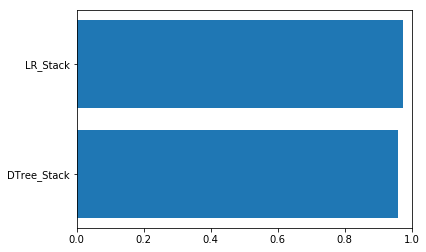

In [249]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

In [277]:
# To find correation between both the stack layer classifier:
b = [accuracydtS]
t = [accuracylrS]
np.correlate(b,t)

array([ 0.95034722])